# Diabetic Retinopathy Detection

In this notebook we show how to use **Bayesian Deep Learning Benchmarks** (**`bdlb`**) for the binary high-resolution image classification Kaggle challenge [Diabetic Retinopathy Detection](https://www.kaggle.com/c/diabetic-retinopathy-detection), $y_{\text{target}} \in \{0,1\}$.

In [1]:
import os

import numpy as np
np.random.seed(0)
# Use TensorFlow as an example,
# compatible with any other
# deep learning framework
import tensorflow as tf

# BDL Benchmarks framework
import bdlb

/home/scratch/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We store the hyperparameters (e.g., global variables) of the experiment in a global container. Feel free to tune and restart the notebook to see their impact on the final results.

In [2]:
# Hyperparameters
HPARAMS = {
    "batch_size": 100,
    "dropout_prob": 0.5,
    "num_epochs": 50,
    "num_MC_samples": 100
}
# Project path
pwd = os.path.abspath("../../")

## Initialize Downstream Task

**`bdlb`** provides three formats for the diabetic retinopathy detection benchmark:

* `DiabetesRealWorld`: The official full dataset (82 GB). This version is intended for the evaluation of proposed techniques at a scale applicable to the real world.
* `DiabetesMedium`: A subsampled version of the full dataset (~33 GB). This version is intended for prototyping and cases where larger data renders proposed techniques computationally infeasible.
* `DiabetesToy`: A simple experiment (~130 MB) based on the feature vectors
$$\{x_{n}\}_{n=1}^{N}, \quad x_{n} \in \mathbb{R}^{512}$$
extracted from a fully-trained VGG16 neural network on the same task. This version is intended for sanity checks and debugging only.

In the interest of quick reproducability of the results of this notebook, we will use the `DiabetesToy` format, which can be easily replaced in one line with any of the other two formats, provided that the data are properly fetched and stored locally and an appropriate model is designed.

In [3]:
dtask = bdlb.tasks.DiabetesToy(os.path.join(pwd, "data/diabetes"))

## Initialize Model

For the Diabetic Retinopathy Detection benchmark we provide baseline implementations for:

* Dropout as a Bayesian approximation [[1](#Yarin-2015)]
* Mean Field Variational Inference [[2](#Peterson-1987)]

In this notebook we implement a single layer neural network (`sigmoid` output activation), trained according to [[1](#Yarin-2015)].

In [4]:
# Define model
inputs = tf.keras.Input(shape=(512,))
x = tf.keras.layers.Dense(1024, activation="relu")(inputs)
x = tf.keras.layers.Dropout(HPARAMS['dropout_prob'])(x, training=True)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(HPARAMS['dropout_prob'])(x, training=True)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
optim = tf.train.AdamOptimizer()
model.compile(loss="binary_crossentropy", optimizer=optim)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 1,575,937
Trainable params: 1,575,937
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluation Loop

In [5]:
# Training & evaluation loops
for epoch in range(HPARAMS["num_epochs"]):
    with dtask.iterate_train(batch_size=HPARAMS["batch_size"]) as it:
        model.fit_generator(it, steps_per_epoch=1, verbose=0)

    if epoch % 5 == 0:
        label_list = []
        predictions = []
        with dtask.iterate_validation(batch_size=HPARAMS["batch_size"]) as it:
            for x, y in it:
                label_list.append(y)
                pred_act = np.mean([model.predict(x) for _ in range(20)], 0)
                predictions.append(pred_act)

        print(dtask.metrics_deterministic(np.concatenate(label_list), np.concatenate(predictions)))

<Accuracy: 0.5011320754716981, auc:0.6385169080254454>
<Accuracy: 0.6077777777777778, auc:0.7960374015564412>
<Accuracy: 0.709811320754717, auc:0.7179738679361889>
<Accuracy: 0.7, auc:0.8319302048039068>
<Accuracy: 0.749811320754717, auc:0.7729540005775772>
<Accuracy: 0.7230188679245283, auc:0.8276458190931877>
<Accuracy: 0.7433962264150943, auc:0.8304716727499737>
<Accuracy: 0.7366037735849057, auc:0.7719637006557213>
<Accuracy: 0.7547169811320755, auc:0.8303056090507623>
<Accuracy: 0.7637735849056604, auc:0.8304549514244572>


## Uncertainty Estimator

In [6]:
def predict(x):
    """Uncertainty estimator function.

    Args:
    x: Input features, `NumPy` array.

    Returns:
    mean: Predictive mean.
    uncertainty: Uncertainty in prediction.
    """
    MC_samples = [model.predict(x) for _ in range(HPARAMS["num_MC_samples"])]
    MC_samples = np.array(MC_samples)
    _MC_samples = np.concatenate([1. - MC_samples, MC_samples], -1)
    expected_p = np.mean(_MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)
    return np.mean(MC_samples, 0), entropy_expected_p

\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage{booktabs}
\usepackage{float}
\usepackage{graphicx}
\usepackage{a4wide}
\title{Diabetes toy benchmark with MC Dropout baseline}
\begin{document}
\maketitle
\begin{figure}[H]
\centering
\includegraphics[width=1.0\linewidth]{acc_plot}
\end{figure}
\begin{figure}[H]
\centering
\includegraphics[width=1.0\linewidth]{auc_plot}
\end{figure}
\begin{figure}[H]
\centering
\includegraphics[width=1.0\linewidth]{roc_plot}
\end{figure}
\begin{table}[H]
\centering
\begin{tabular}{lrr}
\toprule
{} &  Test auc &  Test acc \\
fraction &           &           \\
\midrule
1.0      &  0.817296 &  0.753000 \\
0.9      &  0.829274 &  0.778466 \\
0.8      &  0.841219 &  0.801321 \\
0.7      &  0.851181 &  0.825000 \\
\bottomrule
\end{tabular}
\end{table}
\begin{figure}[H]
\centering
\includegraphics[width=1.0\linewidth]{level_plot}
\end{figure}
\end{document}



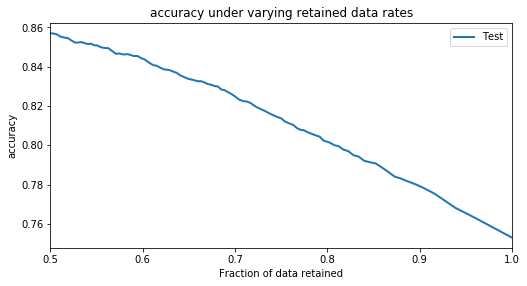

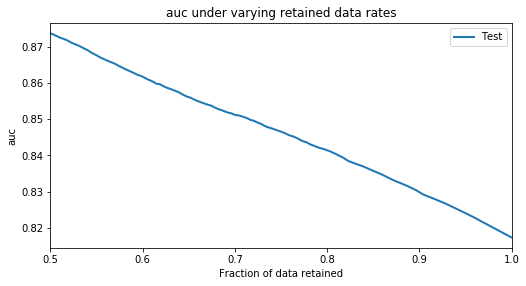

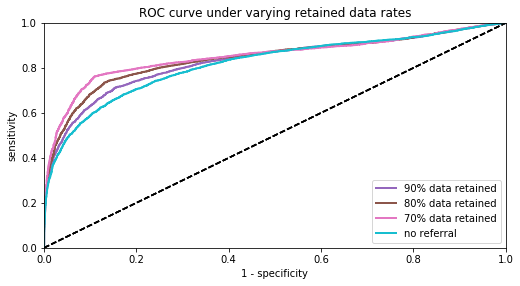

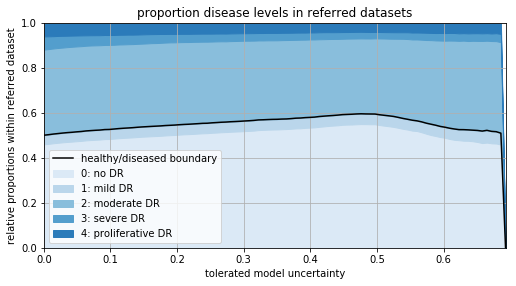

In [7]:
report = dtask.generate_report(predict, batch_size=HPARAMS["batch_size"])
tex = report.to_latex(output_file=os.path.join(pwd, "tmp/results/diabetes/toy/mc_dropout_keras/report.tex"),
                      title="Diabetes toy benchmark with MC Dropout baseline")
# Raw LaTeX report
print(tex)

<a name="Yarin-2015">[1]</a> Yarin Gal and Zoubin Ghahramani. _Dropout as a Bayesian approximation: Representing model uncertainty in deep learning_. arXiv:1506.02142, 2015.

<a name="Peterson-1987">[2]</a> Peterson, C. and Anderson, J. _A mean field theory learning algorithm for neural networks_. Complex Systems, 1(5):995–1019, 1987.

<a name="Leibig-2017">[3]</a> Christian Leibig, Vaneeda Allken, Murat Seçkin Ayhan, Philipp Berens, and Siegfried Wahl. Leveraging uncertainty information from deep neural networks for disease detection.Nature, 7(1):17816, 2017.